### Notebook to collate the normed data from different assessments in neuropsych battery

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

In [2]:
dataset_dir = "/home/nikhil/projects/Parkinsons/qpn"

# manifest
tabular_dir = f"{dataset_dir}/tabular"
manifest_file = f"{tabular_dir}/manifest.csv"

# neuropysch
neuropych_dir = f"{tabular_dir}/assessments/neuropysch/RPQ_neuropsych_norming/"
neuropych_json_dir = f"{neuropych_dir}/JSONs"
normed_scores_dir = f"{neuropych_dir}/normed_scores"

participant_id_col = "Patient #"


### Read manifest (available subjects)

In [3]:
manifest = pd.read_csv(manifest_file)
qpn_participants = manifest["participant_id"].unique()
sessions = manifest["session"].unique()

print(f"n_participants: {len(qpn_participants)}, unique sessions: {sessions}")
manifest.head()

n_participants: 265, unique sessions: ['ses-01' 'ses-02']


,participant_id,visit,session,datatype
0,PD00016,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
1,PD00020,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
2,PD00032,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
3,PD00048,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
4,PD00119,MRI_v1,ses-01,"['anat','dwi','fmap','func']"


### Check available normed assessments and their config

### Fixed issues:
"normed_data" path for:

    i. Stroop_DKefs_Cond_3_INK_Time_sec.xlsx --> Stroop_DKefs_Cond_3_INK_Time_Normed.xlsx
    ii. Stroop_DKefs_Cond_1_COLORS_Time_sec.xlsx --> Stroop_DKefs_Cond_1_COLORS_Time_Normed.xlsx
    iii. Stroop_DKefs_Cond_3_Total_errors.xlsx --> Stroop_DKefs_Cond_3_Total_errors_Normed.xlsx


In [4]:
json_files = os.listdir(neuropych_json_dir)
print(f"n_json_files: {len(json_files)}")

n_json_files: 30


In [5]:
def get_assessment_info(json_path):
    # json_file = os.path.basename(json_path)
    info = pd.read_json(json_path)
    instrument = info["instrument"]
    norming_procedure = instrument["norming_procedure"]
    
    raw_score_col = instrument["raw_score_name"]
    normed_score_col = instrument["normed_score_name"]
    
    data_paths = info["data_paths"]
    normed_data_path = data_paths["normed_data"]
    normed_file_name = os.path.basename(normed_data_path)

    return raw_score_col, normed_score_col, normed_file_name, norming_procedure

In [6]:
# Fix participant ids
participant_id_replace_dict = {"PD00119/T1":"PD00119"}
participant_id_drop_list = ["PD00119/T2","PD00"]
# collate normed scores
scores_df_list = []
for json_file in json_files:
    json_path = f"{neuropych_json_dir}/{json_file}"
    print(f"assessment: {json_file}")
    if json_file in ["TMT_AB_contrast_config.json"]:
        print(f"Ignoring contrast instrument with two raw score cols: {json_file}")
    else:
        raw_score_col, normed_score_col, normed_file_name, norming_procedure = get_assessment_info(json_path)
        normed_data_file = f"{normed_scores_dir}/{normed_file_name}"
        _df = pd.read_excel(f"{normed_data_file}")
        # Fix participant id
        _df[participant_id_col] = _df[participant_id_col].replace(participant_id_replace_dict)
        _df = _df[~_df[participant_id_col].isin(participant_id_drop_list)]
        _df = _df[[participant_id_col, raw_score_col, normed_score_col]]
        
        ## drop duplicates (keep first i.e. baseline assessment for each participant)
        _df = _df.drop_duplicates(subset=[participant_id_col],keep="first")
        _df["norming_procedure"] = norming_procedure
        _df[participant_id_col] = _df[participant_id_col].astype(str).str.strip()
        _df = _df.rename(columns={normed_score_col: "normed_score", raw_score_col: "raw_score"})
        _df["assessment"] = json_file.split(".")[0]
        scores_df_list.append(_df)
        
scores_df = pd.concat(scores_df_list, axis=0)

scores_df.head()
    

assessment: DSB_norming_config.json
assessment: Stroop_DKefs_Cond_3_INK_Time_sec.json
assessment: Semantic_Fluency_Animals_Regression.json
assessment: Brixton_Error.json
assessment: Stroop_DKefs_Cond_1_COLORS_Time_sec.json
assessment: TMT_A_time_seconds.json
assessment: Digit_span_backward_longest_correct.json
assessment: Semantic_Fluency_Animals.json
assessment: HVLT_R_delayed_recall.json
assessment: Stroop_DKefs_Cond_2_WORDS_Time_sec.json
assessment: TMT_AB_contrast_config.json
Ignoring contrast instrument with two raw score cols: TMT_AB_contrast_config.json
assessment: Semantic_Fluency_Actions_norming_config.json
assessment: ClockCommand_norming_config.json
assessment: Clock_Copy.json
assessment: RCFT_Delayed_config.json
assessment: TMTAerrors_norming_config.json
assessment: TMTBerrors_norming_config.json
assessment: PPT_main_nondom.json
assessment: Letter_Fluency_Total.json
assessment: BNTraw_norming_config.json
assessment: RCFT_Immediate_config.json
assessment: PPT_main_dom.json
a

,Patient #,raw_score,normed_score,norming_procedure,assessment
0,PD00209,NaN,NaN,lookup_scaled_score,DSB_norming_config
1,PD00119,NaN,NaN,lookup_scaled_score,DSB_norming_config
2,PD00820,NaN,NaN,lookup_scaled_score,DSB_norming_config
3,PD00262,NaN,NaN,lookup_scaled_score,DSB_norming_config
4,PD00523,NaN,NaN,lookup_scaled_score,DSB_norming_config


### Plots

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

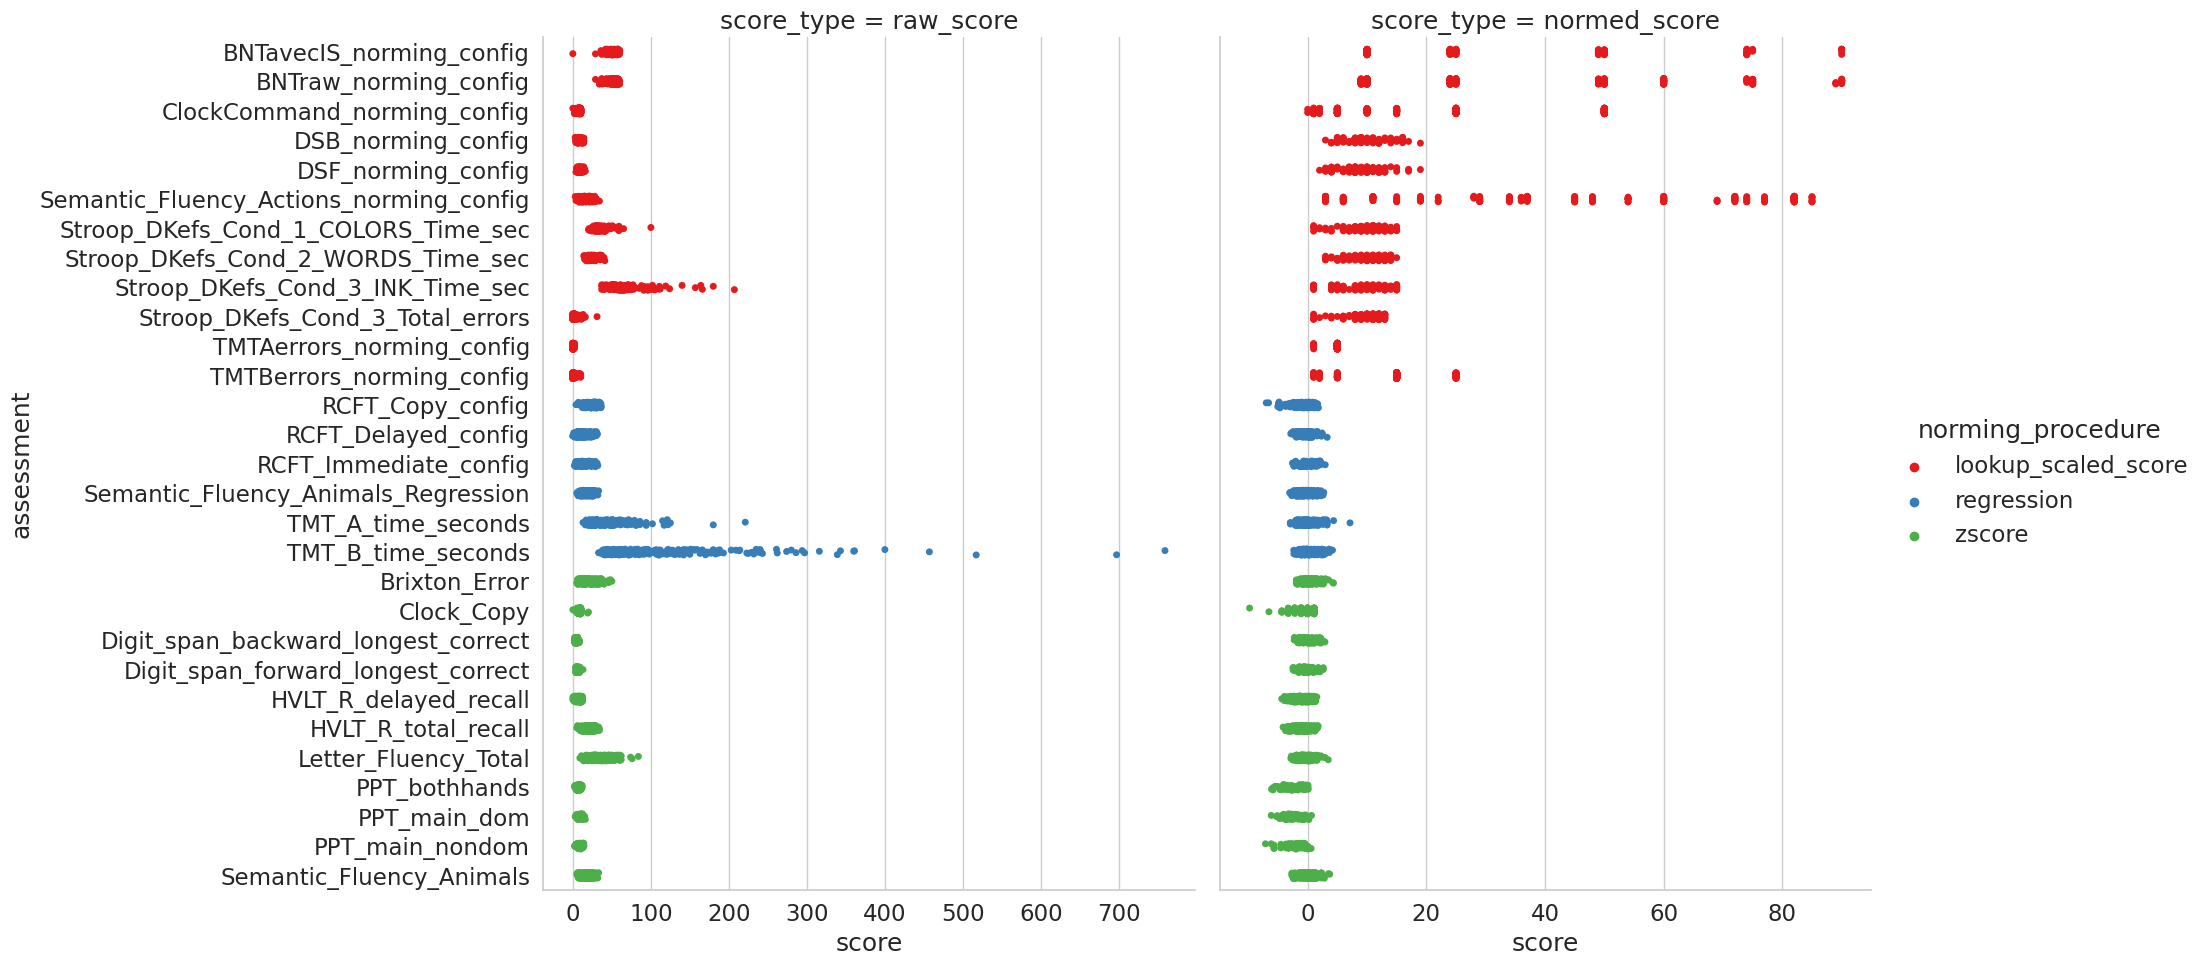

In [7]:
plot_df = pd.melt(scores_df, id_vars=[participant_id_col, "assessment", "norming_procedure"], 
                  value_vars=["normed_score", "raw_score"], value_name="score", var_name="score_type")
plot_df = plot_df.sort_values(by=["score_type", "norming_procedure", "assessment"])
col_order = ["raw_score","normed_score"]
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="score" ,y="assessment", col="score_type", hue="norming_procedure", palette="Set1",  
                    data=plot_df, col_order=col_order, 
                    height=10, kind="strip", sharex=False)


### Find missing participants per assessment

In [8]:
score_availability_df = scores_df.groupby(["assessment"]).count().reset_index().drop(columns=["norming_procedure"])
score_availability_df = score_availability_df.rename(columns={"Patient #": "recruitment_count",
                                                              "raw_score": "raw_score_count",
                                                              "normed_score": "normed_score_count"})

score_availability_df.head()

,assessment,recruitment_count,raw_score_count,normed_score_count
0,BNTavecIS_norming_config,282,167,167
1,BNTraw_norming_config,282,253,253
2,Brixton_Error,273,263,263
3,ClockCommand_norming_config,282,279,274
4,Clock_Copy,282,278,276


In [9]:
raw_score_wide_df = scores_df.pivot(index=participant_id_col, columns="assessment", values="raw_score")
normed_score_wide_df = scores_df.pivot(index=participant_id_col, columns="assessment", values="normed_score")

In [10]:
scores_df.to_csv(f"{neuropych_dir}/collated_scores_longform.csv", index=False)
raw_score_wide_df.to_csv(f"{neuropych_dir}/raw_score_wideform.csv", index=True)
normed_score_wide_df.to_csv(f"{neuropych_dir}/normed_score_wideform.csv", index=True)
score_availability_df.to_csv(f"{neuropych_dir}/score_availability.csv", index=False)

### Compare with manifest

In [11]:
neurospych_participants = scores_df[participant_id_col].unique()
print(f"n_neurospych_participants: {len(neurospych_participants)}")
scores_df.head()

n_neurospych_participants: 282


,Patient #,raw_score,normed_score,norming_procedure,assessment
0,PD00209,NaN,NaN,lookup_scaled_score,DSB_norming_config
1,PD00119,NaN,NaN,lookup_scaled_score,DSB_norming_config
2,PD00820,NaN,NaN,lookup_scaled_score,DSB_norming_config
3,PD00262,NaN,NaN,lookup_scaled_score,DSB_norming_config
4,PD00523,NaN,NaN,lookup_scaled_score,DSB_norming_config


In [12]:
neuropsy_and_qpn = set(neurospych_participants ) & set(qpn_participants)
not_in_qpn = set(neurospych_participants ) - set(qpn_participants)
not_in_neuropsy = set(qpn_participants) - set(neurospych_participants )

print(f"n_neuropsy_and_qpn: {len(neuropsy_and_qpn)}, n_not_in_qpn: {len(not_in_qpn)}, n_not_in_neuropsy: {len(not_in_neuropsy)}")

n_neuropsy_and_qpn: 165, n_not_in_qpn: 117, n_not_in_neuropsy: 100
